Import All ressources, set float show for pandas

In [1]:
import pandas as pd
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip"
urllib.request.urlretrieve(url, "./fr.openfoodfacts.org.products.csv.zip")
pd.set_option('display.float_format', '{:.2f}'.format)

Navigate in the zip to load the csv to df

In [2]:
with zipfile.ZipFile("./fr.openfoodfacts.org.products.csv.zip", 'r') as zipRef:
    with zipRef.open('fr.openfoodfacts.org.products.csv') as file:
        data = pd.read_csv(file, sep="\t", low_memory=False)

Divide output in 2, All metadata and qualitative first, the nutri data in second
Show all features detail : https://world.openfoodfacts.org/data/data-fields.txt
To select our main feature show the ones with more 50% not null in the df

In [3]:
varList = data.columns.tolist()
print(varList)
sizeData = data.shape[0]
startNut = varList.index("energy_100g")
missingRate = data.iloc[:, :startNut].isnull().sum()/sizeData
missingRateNut = data.iloc[:, startNut:].isnull().sum()/sizeData
pd.set_option('display.max_rows', None)
print(missingRate[missingRate < 0.50])
print(missingRateNut[missingRateNut < 0.50])

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

nutrition_grade_fr will be my principal feature, the target of the db is this feature, it's qualitative and with 69% not Nan in the file


'energy_100g',
'fat_100g',
'saturated-fat_100g', 
'sugars_100g' ,
'salt_100g', 
'sodium_100g',
'fiber_100g',
'proteins_100g',
'fruits-vegetables-nuts_100g'
I want to keep these features for the main feature nutrition_grade_fr because they are connected to it. they are main variables of the calculation of nutrition-score-fr_100g wich is use with categorie to give a nutrition_grade_fr letter

In [4]:
def prepareData(data, targetColumn, subsetDup, keep, filter):
    if targetColumn not in data.columns:
        raise ValueError(f"{targetColumn} is not in dataFrame.")
    dataCleaned = data.dropna(subset=[targetColumn]).copy()
    if subsetDup:
        dataCleaned = dataCleaned.drop_duplicates(subset=subsetDup)
    else:
        print("No target for subsetDup.")
        
    if 'countries_tags' in dataCleaned.columns:
        dataCleaned['countries_tags'] = dataCleaned['countries_tags'].fillna('')
        dataCleaned = dataCleaned[dataCleaned['countries_tags'].str.contains('en:france')]
    dataCleaned = dataCleaned[keep]
    y = dataCleaned[targetColumn]
    X = dataCleaned
    
    
    return X, y

Creation of all function to manipulate or show the data

In [67]:
def createBarplot(ax, data, col, max_categories=24):
    valueCounts = data[col].value_counts()
    if len(valueCounts) > max_categories:
        plt.xticks(rotation=90, ha='right')
        top_categories = valueCounts.head(max_categories)
        other_count = valueCounts.iloc[max_categories:].sum()
        other_series = pd.Series([other_count], index=['Other'])
        plot_data = pd.concat([top_categories, other_series])
    else:
        plot_data = valueCounts
    sns.barplot(x=plot_data.index, y=plot_data.values, ax=ax)
    ax.set_title(f'Count of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    

def plotBarplots(data, columns):
    numCols = len(columns)
    
    fig, axes = plt.subplots(numCols, 1, figsize=(15, 5 * numCols))
    axes = np.array(axes).flatten()
    
    list(map(createBarplot, axes[:numCols], [data]*numCols, columns))
    
    plt.show()

In [6]:
def createBoxplot(ax, data, col):
    sns.boxplot(x=data[col], ax=ax)
    ax.set_title(f'Distribution of {col}')

def plotBoxplots(data, columns):
    numCols = len(columns)
    numRows = numCols // 3 + (numCols % 3 > 0)
    
    fig, axes = plt.subplots(numRows, 3, figsize=(15, 5 * numRows))
    axes = np.array(axes).flatten()
    
    list(map(createBoxplot, axes[:numCols], [data]*numCols, columns))
    
    plt.tight_layout()
    plt.show()

In [7]:
def createSubplot(ax, data, col):
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
    
def plotHistograms(data, columns):
    numCols = len(columns)
    numRows = numCols // 3 + (numCols % 3 > 0)
    
    fig, axes = plt.subplots(numRows, 3, figsize=(15, 5 * numRows))
    axes = np.array(axes).flatten()
    
    list(map(createSubplot, axes[:numCols], [data]*numCols, columns))
    
    plt.tight_layout()
    plt.show()   


In [8]:
def checkConvert(value, minVal, maxVal):
    if value < minVal or value > maxVal:
        return np.nan
    return value
            
def treatOutliers(data, thresholds):
    dataClean = data.copy()
    for col, (minVal, maxVal) in thresholds.items():
        if col in data.columns:
            dataClean[col] = dataClean[col].apply(lambda x: checkConvert(x, minVal, maxVal))
    return dataClean

In [9]:
def missingVar(data):
	missing_percentages = (data.isnull().mean() * 100).sort_values(ascending=False)
	plt.figure(figsize=(12, 6))
	missing_percentages.plot(kind='bar')
	plt.title('Missing %')
	plt.xlabel('columns')
	plt.ylabel('% missing')
	plt.xticks(rotation=90)
	plt.tight_layout()
	plt.show()

In [10]:
def imputeMissingValues(d, fillZ, fillMedian, fillImputer, fillUnknown, remove):
    data = d.copy()
    data.dropna(subset=remove ,how='all')
    for col in fillZ:
        data[col] = data[col].fillna(0)
    imputer = KNNImputer(n_neighbors=5)
    data[fillImputer] = imputer.fit_transform(data[fillImputer])
    for col in fillMedian:
        data[col] = data[col].fillna(data[col].median())
    for col in fillUnknown:
        data[col] = data[col].fillna('unknown')
    return data

In [11]:
def plotpairplots(data, col):
	sns.set_theme(style="ticks")
	sns.pairplot(data[col], diag_kind="kde", markers="o", plot_kws={'alpha': 0.6})
	plt.tight_layout()
	plt.show()


In [12]:

def createBoxplotSubplot(x, ax, var, data, y, order):
    sns.boxplot(x=x, y=var, data=pd.concat([data, y], axis=1), ax=ax, order=order)
    ax.set_title(f'{var} per nutri grade')

def multiBoxPlots(x, data, y, numericColumns):
    numCols = len(numericColumns)
    data = data.drop(x, axis=1)
    fig, axes = plt.subplots(numCols, 1, figsize=(15, 40))
    order = ['a', 'b', 'c', 'd', 'e']
    list(map(createBoxplotSubplot, [x] * numCols, axes, numericColumns, [data] * numCols, [y] * numCols, [order] * numCols))
    plt.tight_layout()
    plt.show()



In [13]:
def corrplot(data, y, col, yNumeric):
	dataCombined = pd.concat([data[col], yNumeric], axis=1)
	correlations = dataCombined[col + [yNumeric.name]].corr()[yNumeric.name].sort_values(ascending=False)
	plt.figure(figsize=(12, 8))
	sns.barplot(x=correlations.index, y=correlations.values)
	plt.title('Correlation with nutri grade')
	plt.xticks(rotation=45, ha='right')
	plt.ylabel('Correlation coefficient')
	plt.show()

In [14]:
def heatplot(data, col):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data[col].corr(), 
                annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation heatmap')
    plt.show()

In [15]:
def plotScaler(data, col, categories=None):
    scaler = StandardScaler()
    XScaled = scaler.fit_transform(data[col])

    pca = PCA()
    XPca = pca.fit_transform(XScaled)

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))

    ax[0, 0].plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
    ax[0, 0].set_xlabel('Number of components')
    ax[0, 0].set_ylabel('Cumulative explained variance')
    ax[0, 0].set_title('Scree Plot')

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    print(f'Cumulative variance ratio for 2 components: {cumulative_variance_ratio[1]*100:.2f}%')

    feature_names = data[col].columns
    if len(feature_names) > 2:
        for i in range(len(feature_names)):
            ax[0, 1].arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
                           head_width=0.05, head_length=0.05, color='blue')
    
        for i, feature in enumerate(feature_names):
            ax[0, 1].text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15, feature,
                          color='black', ha='center', va='center')
    
        ax[0, 1].set_xlim(-1, 1)
        ax[0, 1].set_ylim(-1, 1)
        ax[0, 1].set_xlabel('Principal Component 1')
        ax[0, 1].set_ylabel('Principal Component 2')
        ax[0, 1].set_title('Correlation Circle')
        ax[0, 1].grid()

    if categories is not None:
        scatter = ax[1, 0].scatter(XPca[:, 0], XPca[:, 1], c=categories, cmap='viridis', alpha=0.5)
        ax[1, 0].set_xlabel('First principal component')
        ax[1, 0].set_ylabel('Second principal component')
        ax[1, 0].set_title('Projection of Individuals')
        cbar = plt.colorbar(scatter, ax=ax[1, 0], label='Category')

    plt.tight_layout()
    plt.show()

In [16]:
def anova(data, y, numericColumns):
    for var in numericColumns:
        if var in data.columns:
            groups = [group for _, group in data[var].groupby(y)]
            f_value, p_value = stats.f_oneway(*groups)
            print(f"ANOVA for {var}:")
            print(f"F-value: {f_value}")
            print(f"p-value: {p_value}")
            print("\n")

In [17]:
def NanHeatmap(data):
	plt.figure(figsize=(12, 10))
	sns.heatmap(data.isnull(), cbar=False)
	plt.xticks(rotation=45, ha='right')
	plt.title('Missing values heatmap')
	plt.show()

Set parameters will be used in the program, that help to adatp if I want a quick change of the dataframe

In [18]:
outlierThresholds = {
    'energy_100g': (0, 3699),
    'fat_100g': (0, 100),
    'fiber_100g': (0, 34),
    'saturated-fat_100g': (0, 51),
    'sugars_100g': (0, 100),
    'salt_100g': (0, 20),
    'proteins_100g': (0, 90),
    'fruits-vegetables-nuts_100g' : (0, 100)
}
subsetDup = ['code']   
numericColumns = [
    'energy_100g', 
    'fat_100g',
    'saturated-fat_100g', 
    'sugars_100g' ,
    'salt_100g', 
    'fiber_100g',
    'proteins_100g',
    'fruits-vegetables-nuts_100g'
    ]
qualitativeColumns =[
        'nutrition_grade_fr',
        'brands',
    ]
gradeMapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}

 **Filter individuals where the main feature is available:**
   - Ensure that the dataset contains the column for the main feature.
   - Remove individuals (rows) where the main feature is missing.

 **Filter individuals where the country they are sold in is France:**
   - Ensure that the dataset contains a column for the country.
   - Keep only the individuals (rows) where the country is France.

 **Select specific features:**
   - Ensure that the dataset contains all the selected features.
   - Keep only these selected features to reduce memory usage during further manipulation.

In [19]:
numericColumns = [col for col in numericColumns if col in data.columns]
qualitativeColumns = [col for col in qualitativeColumns if col in data.columns]
featureKeep = numericColumns + qualitativeColumns

print(f'Features : {featureKeep}')
XClean, y = prepareData(data, 'nutrition_grade_fr', subsetDup, featureKeep, 'en:france')


Features : ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'salt_100g', 'fiber_100g', 'proteins_100g', 'fruits-vegetables-nuts_100g', 'nutrition_grade_fr', 'brands']


Add index to our main feature to use it later

In [20]:
if gradeMapping is not None:
	yNumeric = y.map(gradeMapping)
else:
	yNumeric = y


Now we see the characteristic of our selected features and their individuals

In [21]:
print("Data frame cleaned")
print("Nb raws after clean :", len(XClean))
print("Nb features:", XClean.shape[1])
print(XClean.describe())


Data frame cleaned
Nb raws after clean : 61415
Nb features: 10
       energy_100g  fat_100g  saturated-fat_100g  sugars_100g  salt_100g  \
count     61334.00  44205.00            61334.00     61334.00   61334.00   
mean       1181.55     13.34                5.44        13.40       1.08   
std       13171.19     16.77                8.55        19.03       3.81   
min           0.00      0.00                0.00        -0.10       0.00   
25%         435.00      1.40                0.30         1.00       0.08   
50%        1041.00      7.00                2.00         4.00       0.55   
75%        1661.00     21.00                7.40        17.90       1.23   
max     3251373.00    380.00              210.00       104.00     211.00   

       fiber_100g  proteins_100g  fruits-vegetables-nuts_100g  
count    44791.00       61334.00                      2762.00  
mean         2.54           7.74                        30.11  
std          4.61           7.84                        32.1

Clean Outliers, the outliers parameters show all values
I choose to not do any modifications for extreme values because they are possible value but I will prefere median than means due to extreme values in this df

In [22]:
XClean = treatOutliers(XClean, outlierThresholds)
print("Outliers treated")


Outliers treated


Show the heatmap of the missing value to see the shape of the missings

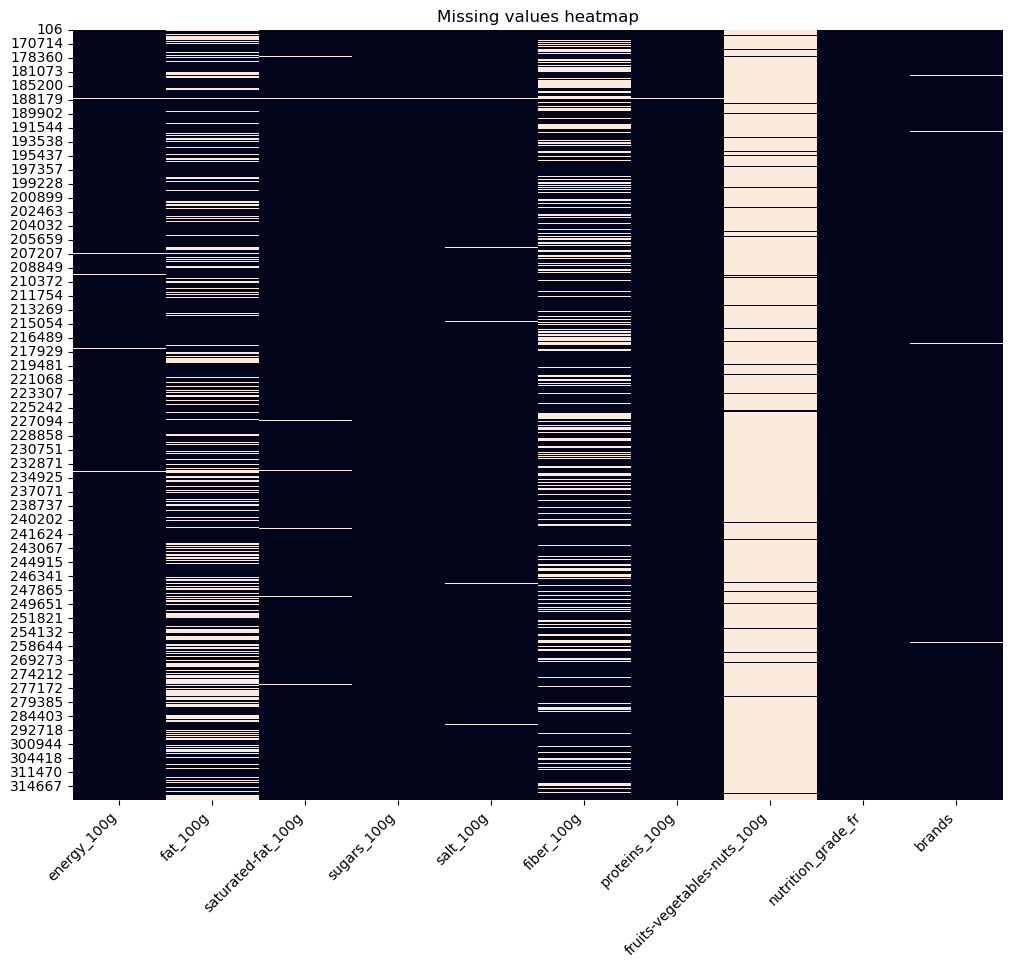

In [23]:
NanHeatmap(XClean)

Some have no value in, so I choose to remove them from dataframe
For fruits and vegetables, fiber I choose to fill with 0 because there is a lot of food without this
For fat and energy I choose to use KNN method because they have a lot of other value available
For all other quantitative I will use the median because they have not a lot of missing values, and not means because of extreme values
For brand I will put unknown as a categori for them

In [24]:
fillZ = ['fiber_100g', 'fruits-vegetables-nuts_100g']
fillUnknown = ['brands']
fillImputer = ['fat_100g', 'energy_100g']
fillMedian = ['sugars_100g', 'saturated-fat_100g', 'salt_100g', 'proteins_100g']
remove = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fruits-vegetables-nuts_100g']
XImputed = imputeMissingValues(XClean, fillZ, fillMedian, fillImputer, fillUnknown, remove)
print("Missing values imputed")
print("\nDescriptive statistics")
print(XImputed.describe())

Missing values imputed

Descriptive statistics
       energy_100g  fat_100g  saturated-fat_100g  sugars_100g  salt_100g  \
count     61415.00  61415.00            61415.00     61415.00   61415.00   
mean       1111.77     13.47                4.94        13.38       0.89   
std         757.21     16.25                6.73        19.01       1.41   
min           0.00      0.00                0.00         0.00       0.00   
25%         435.00      1.70                0.30         1.00       0.08   
50%        1042.00      8.00                1.90         4.00       0.55   
75%        1653.00     20.00                7.00        17.80       1.20   
max        3699.00    100.00               51.00       100.00      20.00   

       fiber_100g  proteins_100g  fruits-vegetables-nuts_100g  
count    61415.00       61415.00                     61415.00  
mean         1.74           7.72                         1.35  
std          3.16           7.75                         9.24  
min         

Now we have a new describe where whe see the global state of our features

-----------------------------------------------------------------

### Univariate analysis
#### The quantitaive features, with boxplots and Histograms

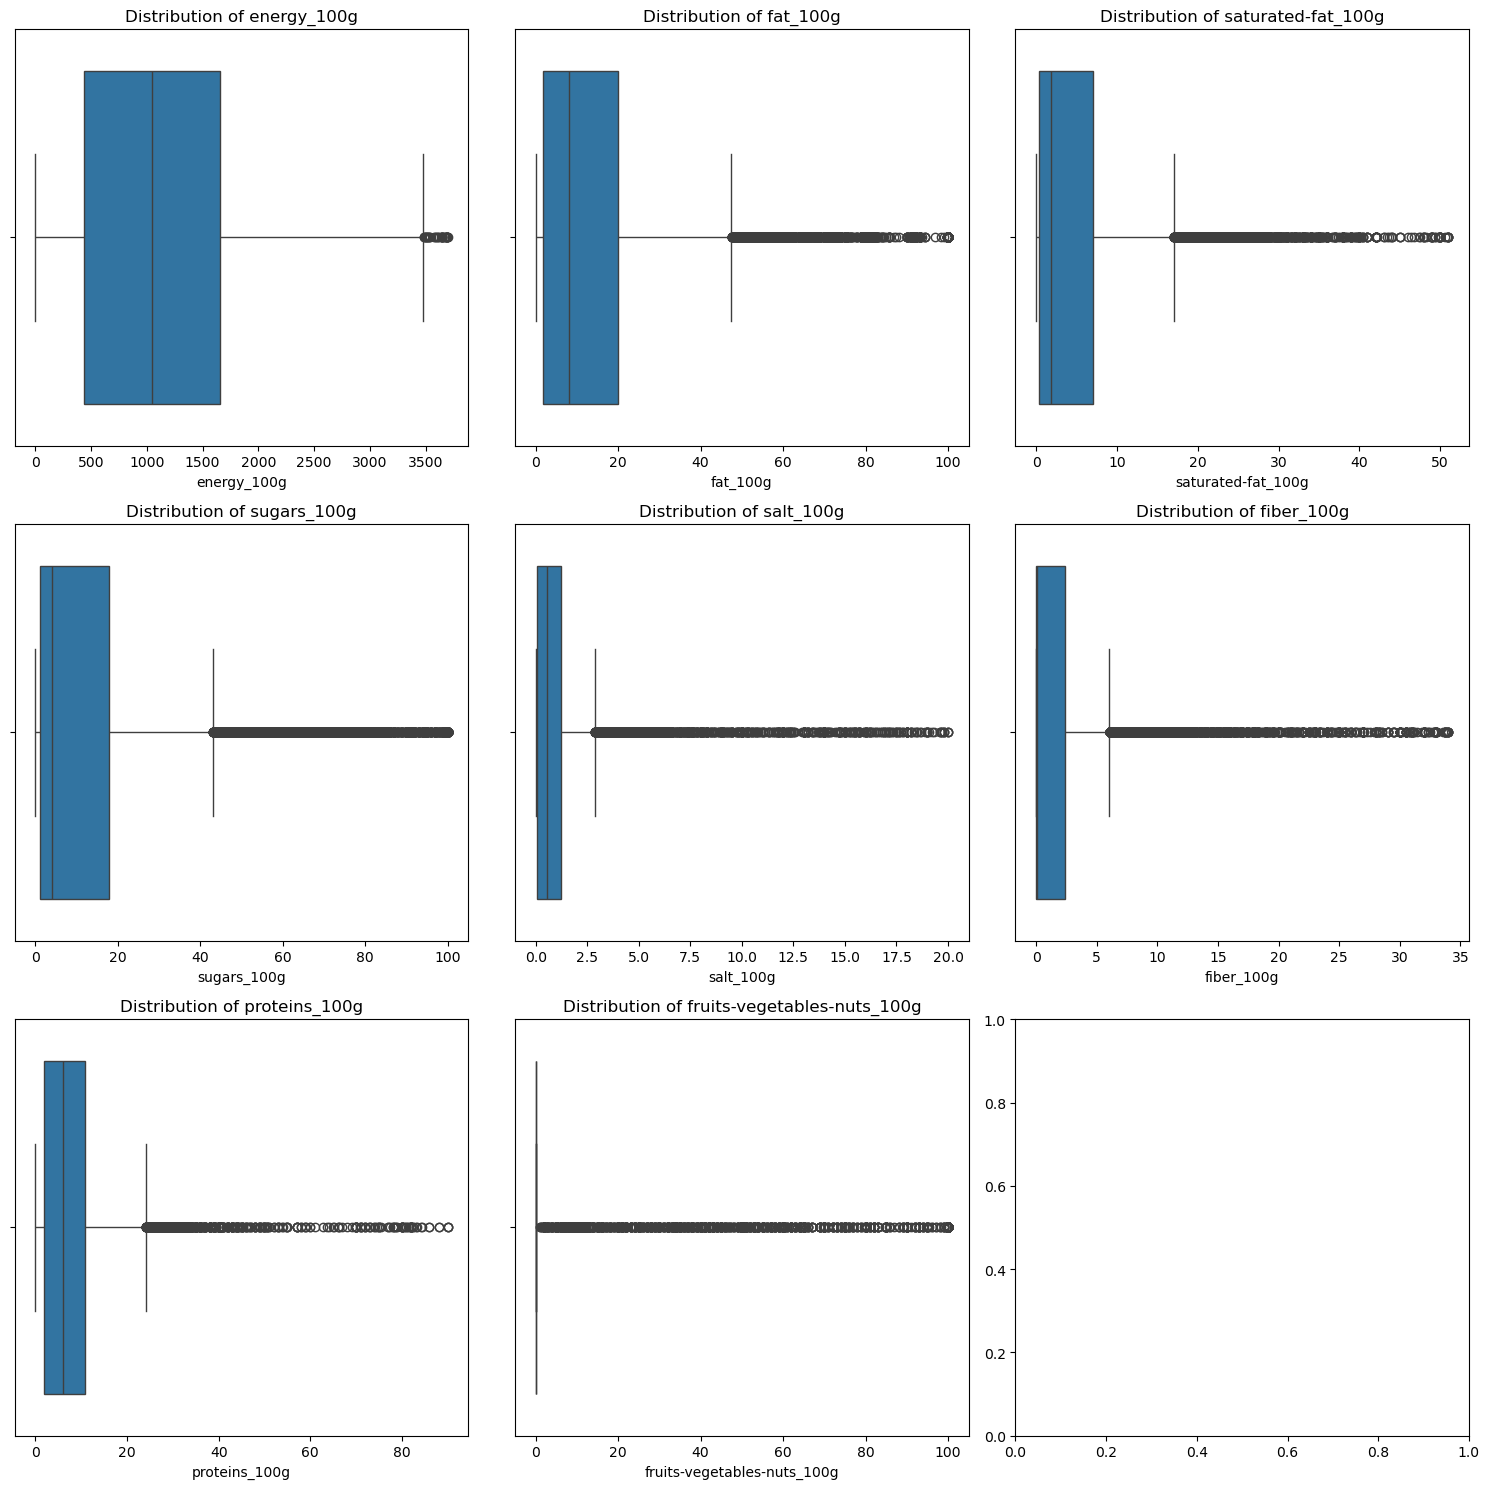

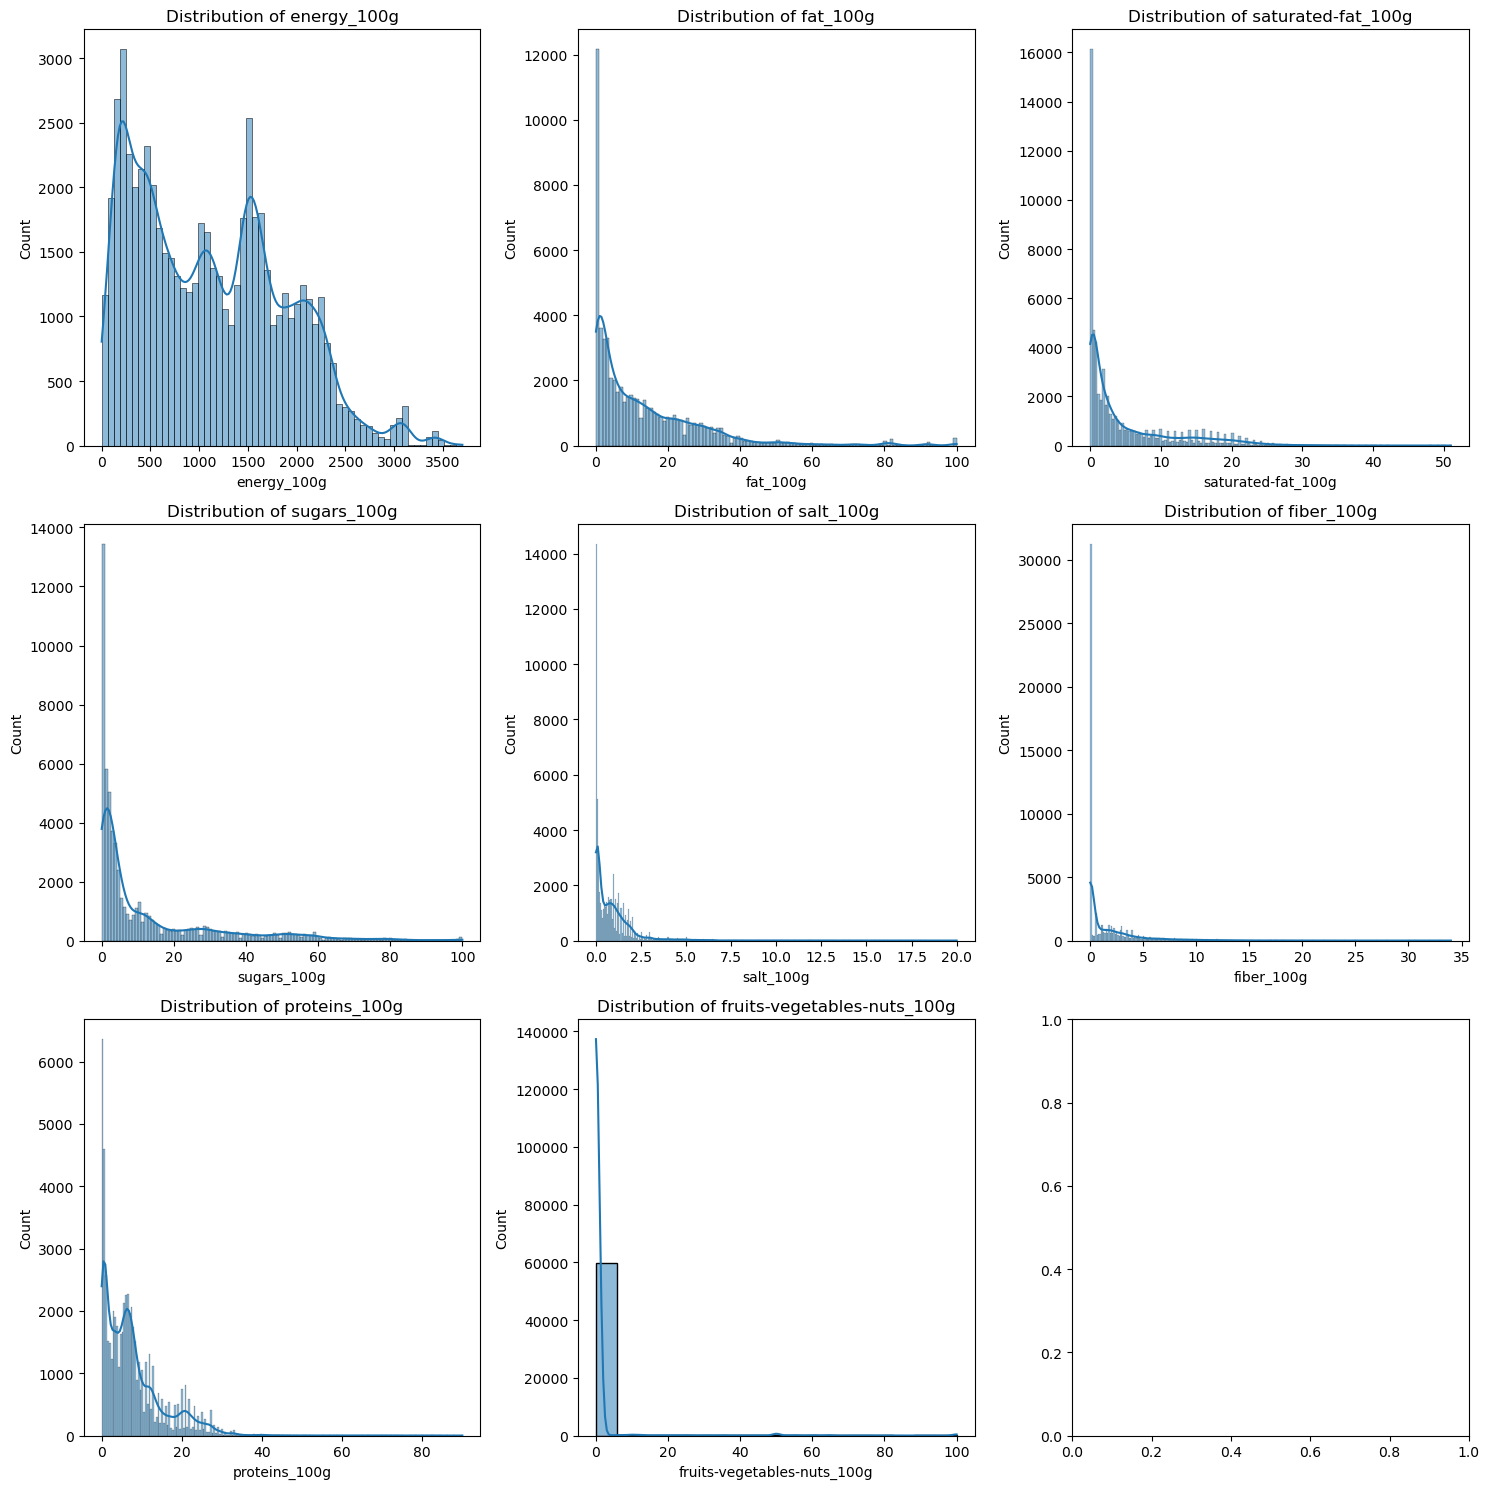

In [25]:
plotBoxplots(XImputed, numericColumns)
plotHistograms(XImputed, numericColumns)

We can see how the value are distribuate, for a lot of them majority of the values are low but have some extreme individuals, except for energy where the distribution is more share 

---------------------------------------------------------------

#### The Qualitative features
##### Bar plots

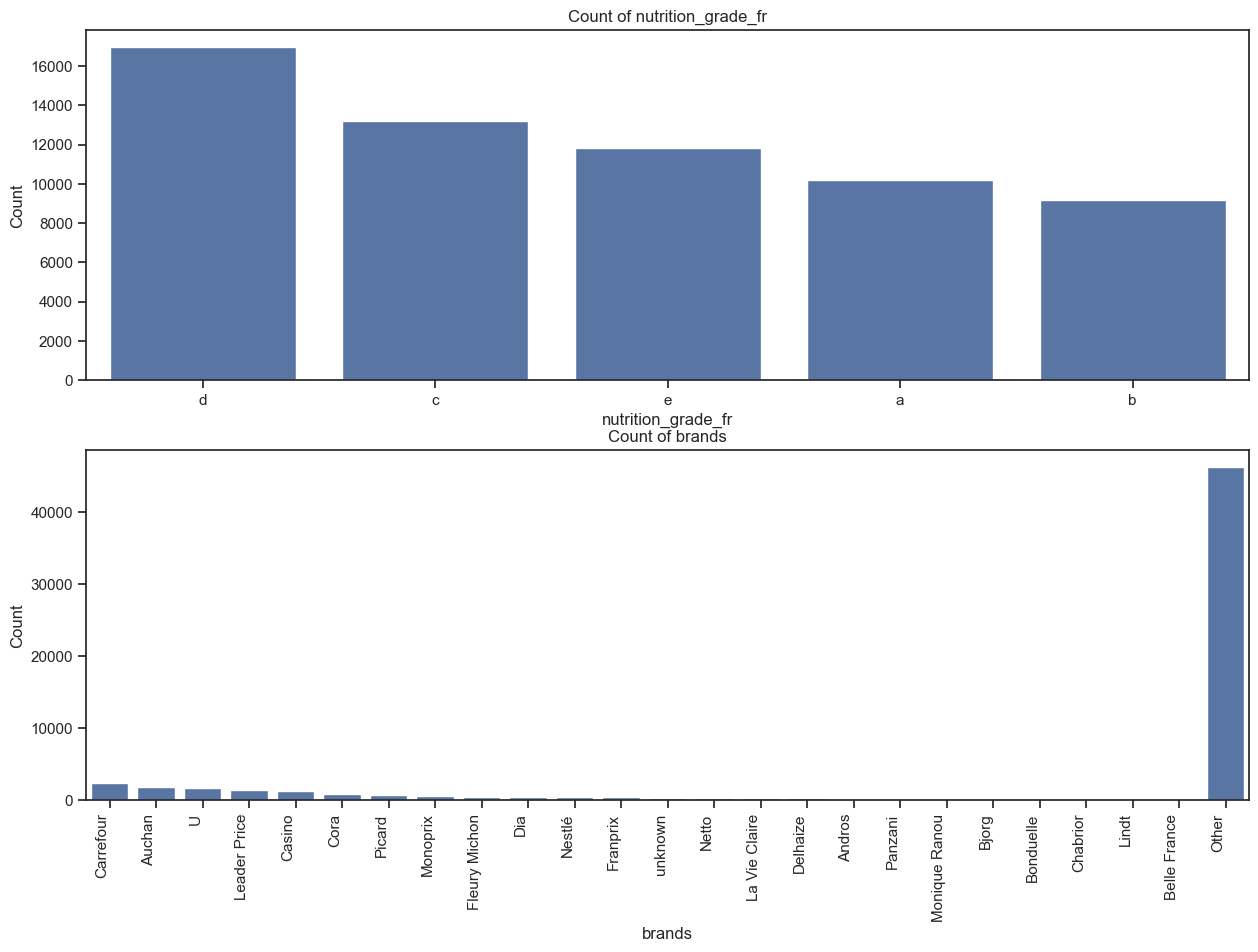

nutrition_grade_fr
d   0.28
c   0.21
e   0.19
a   0.17
b   0.15
Name: proportion, dtype: float64


In [68]:
plotBarplots(XImputed, qualitativeColumns)
print(y.value_counts(normalize=True))


We see the share of the grades, exept d with 28% of the individuals, all the rest is stacked, we have a good share for the grade study

We see brands with with the big part of the individuals have only a small proportion, so the products are produce by a big diversity of companies 

### Bivariate analysis
#### Quantitative with pairplots

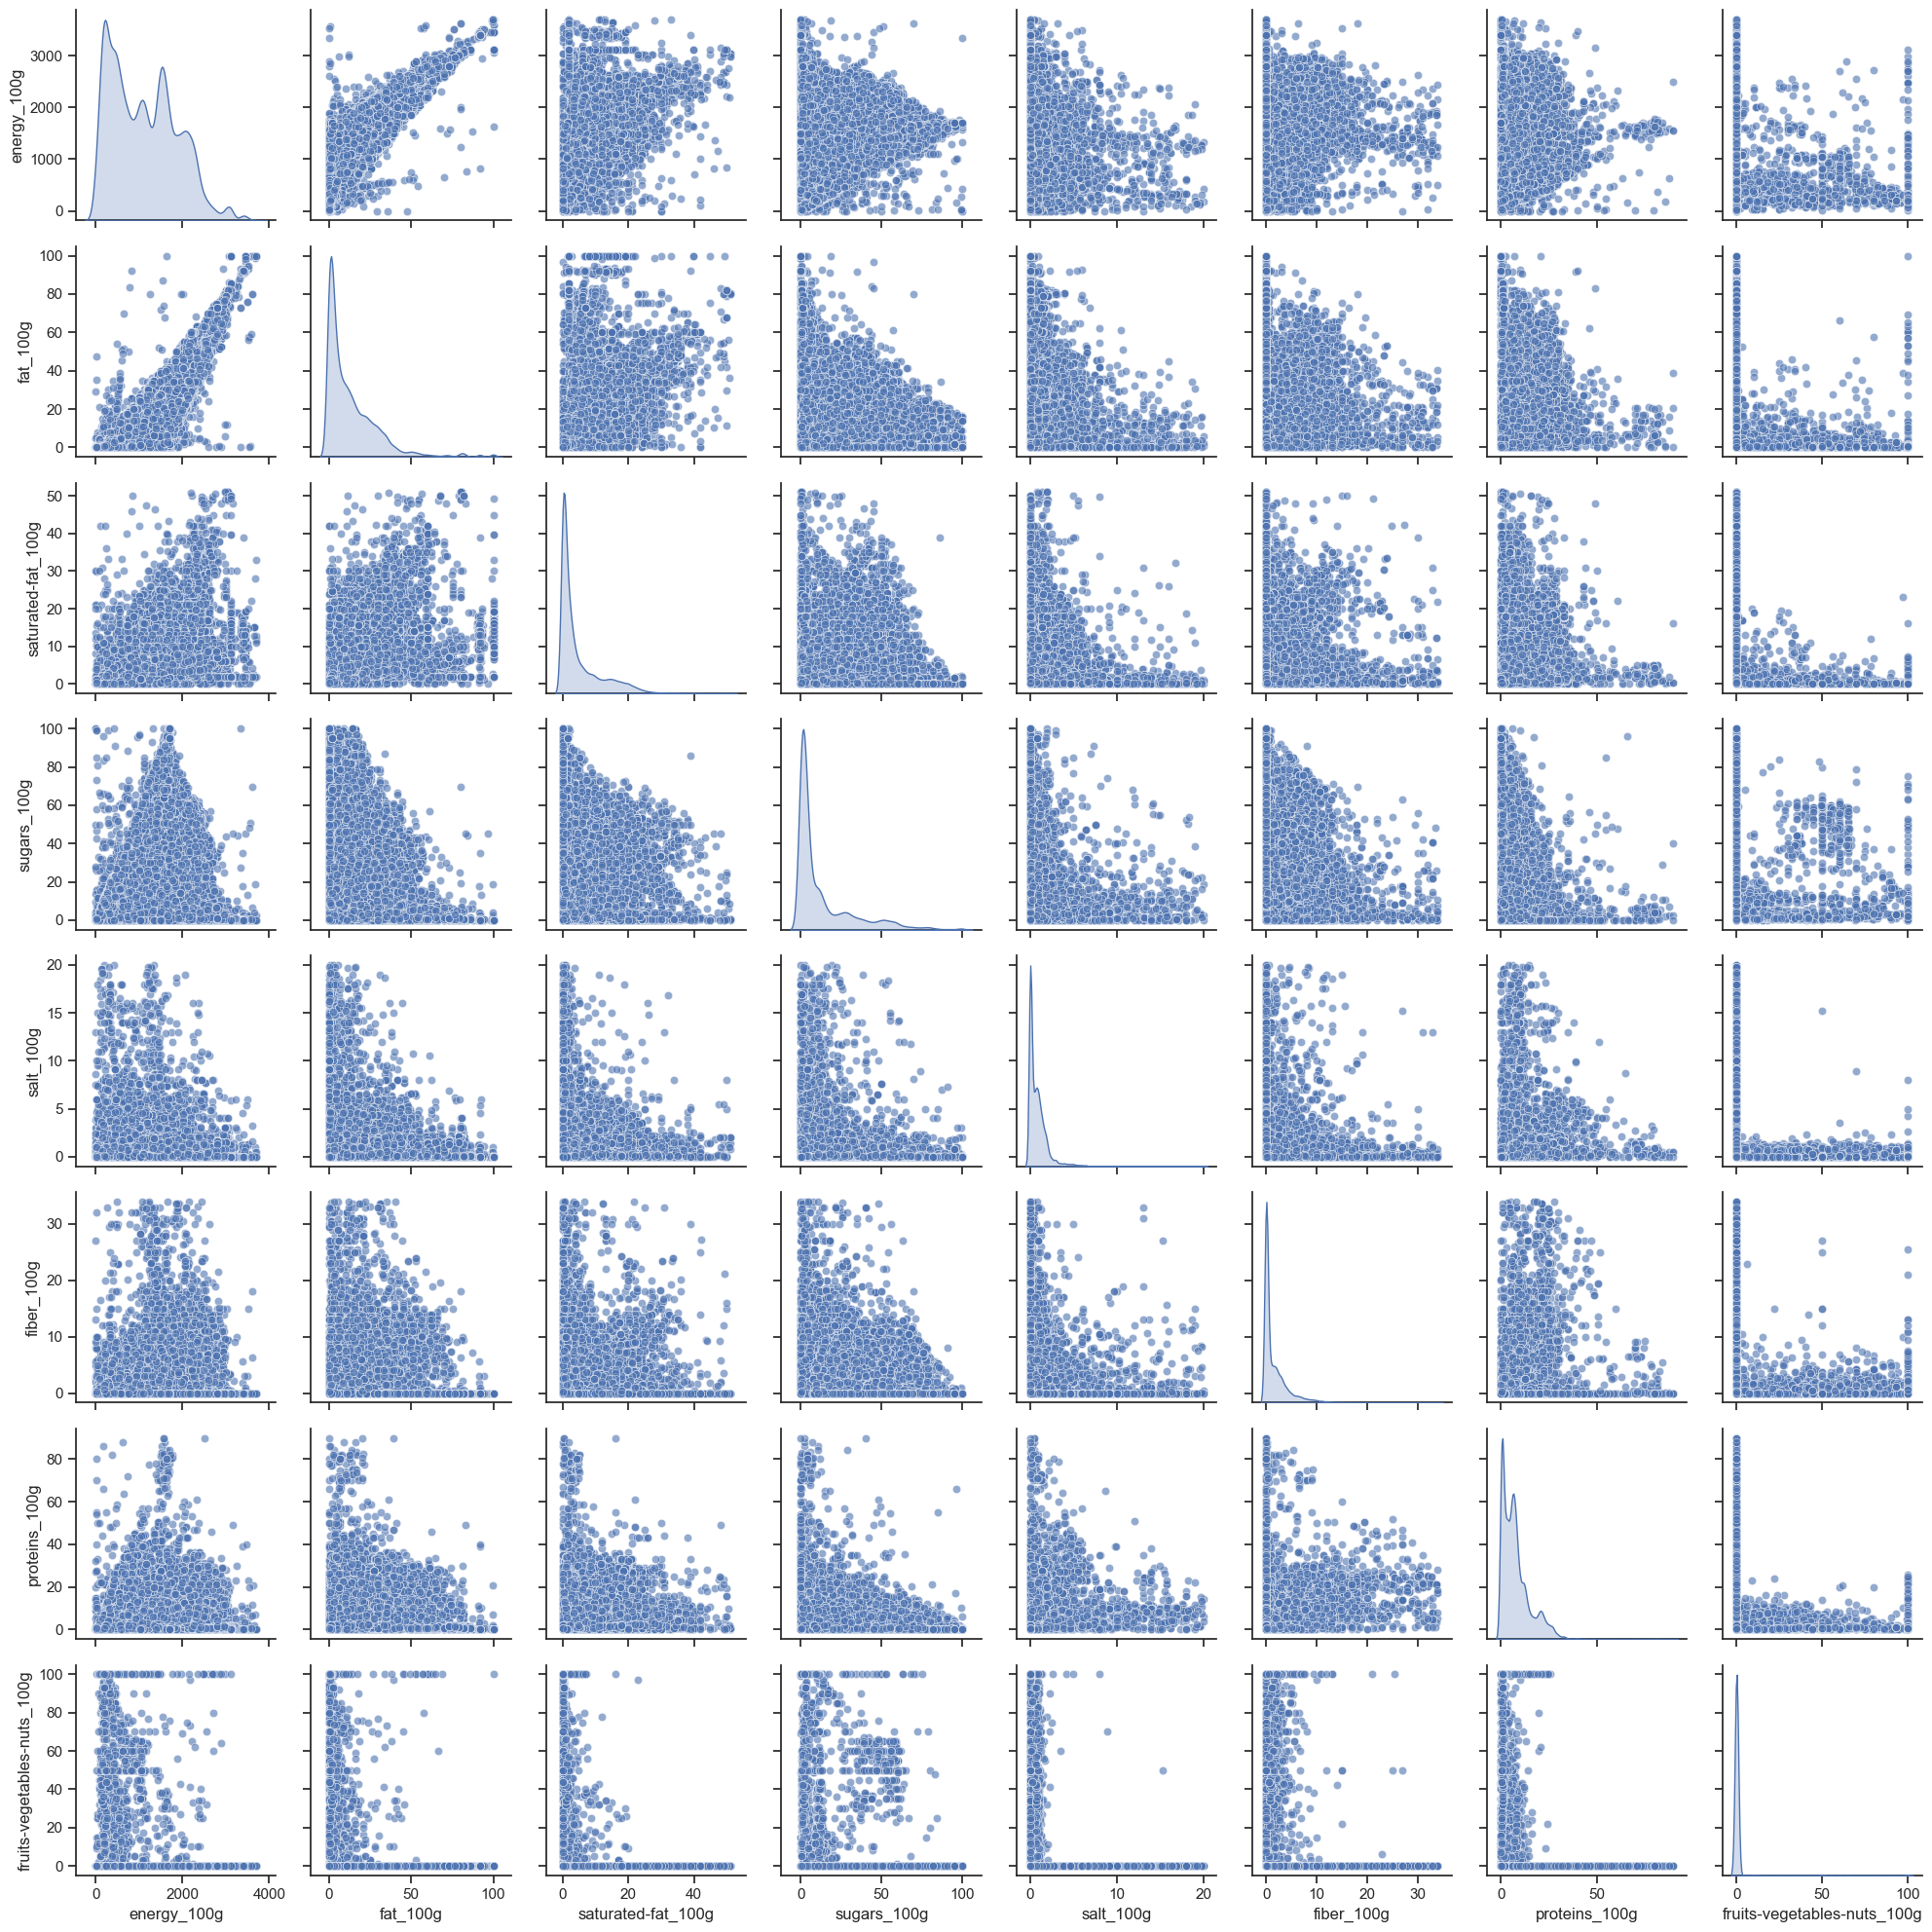

In [70]:

plotpairplots(XImputed, numericColumns)


we see some result of our imputation by 0 on fruits and on fiber, we choose that because is highly possible to have no fiber or fruits in the individual

 **Some feature show some indications:**
   - energy whith fat show a zone where a linare corelation is visible
   - some features like saturated fat and salt show a zone where one is hight the other is low, or both middle
   - energy and sugar show a different form where result a different repartition

#### Qualitative and quantitative with Multi BoxPlots

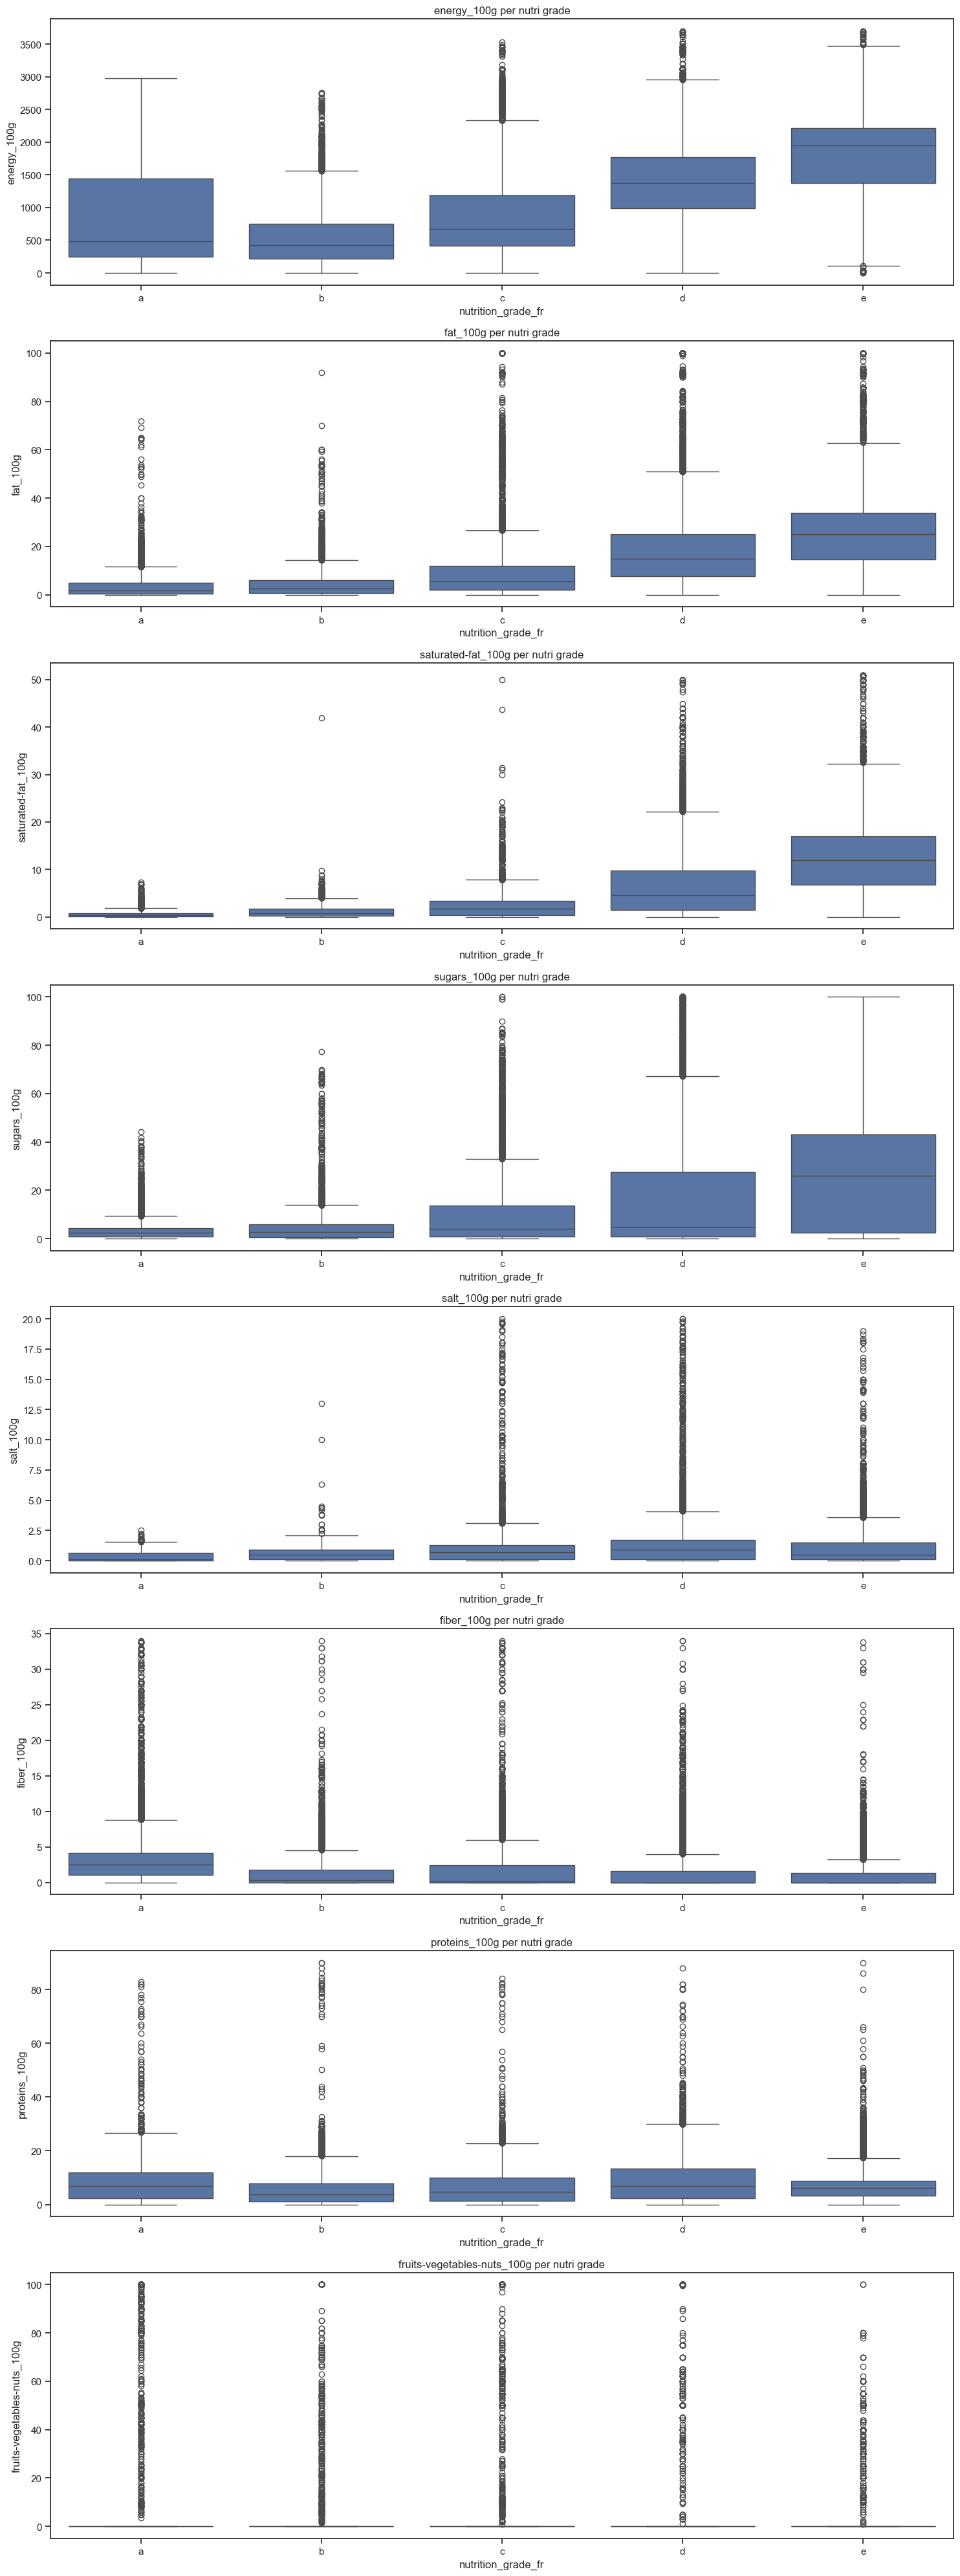

In [71]:
multiBoxPlots('nutrition_grade_fr', XImputed, y, numericColumns)

 **Intresting features compare with nutrition grade fr:**
   - sugar, salt, fat, saturated fat have a bit the same draw where the box is compress to low value in A grade until E have big box and cover a lot of values
   - for energy it show a A with a lot of different value but from B to E show the same as bellow
   - the numbers of value for fruits make it hard to interprate, but we see more individuals in A than the others and E with less individuals than the others

#### See the correlation between the main features and the others with Correlation plots
here I start to use the convertion from A to 1, B to 2, ...

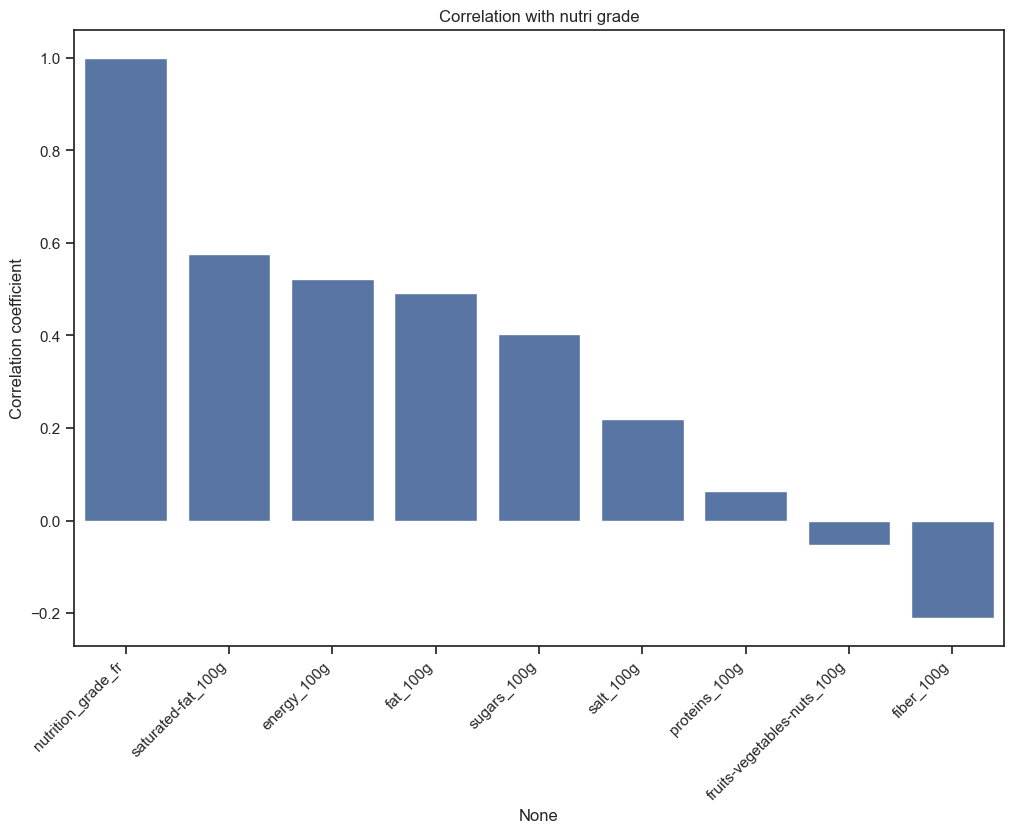

In [72]:

corrplot(XImputed, y, numericColumns, yNumeric)


- On Nutrition grade fr, we can see a medium correlation with saturated fat, energy, fat, sugar, and a bit lower than the others salt, which mean when an individual have the value of this hight it have bigger chance to have a bigger grade
- Proteins have a small correlation with the grade
- Fruits, and Fiber have a negative impact which mean when a individuals have one or both it can below grade

### Show a 2d view of a multidimentional data with PCA

Cumulative variance ratio for 2 components: 50.17%


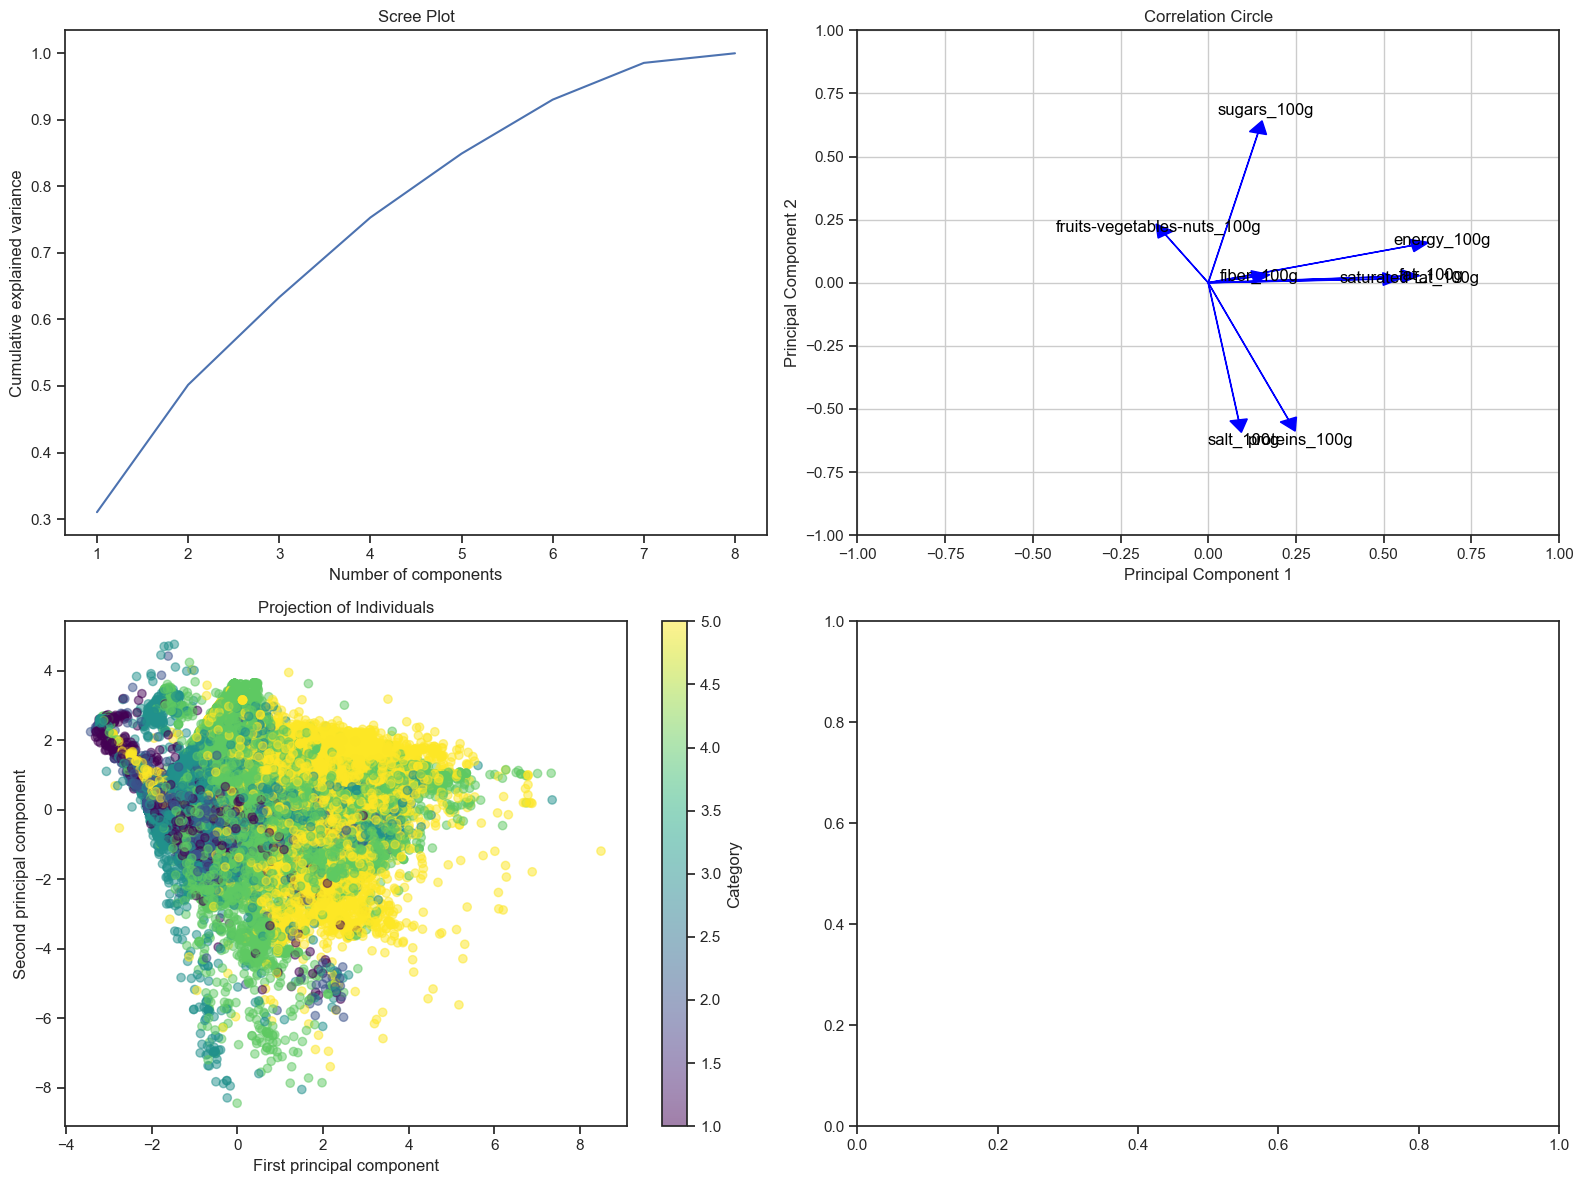

In [73]:
plotScaler(XImputed, numericColumns, yNumeric)

 **Scree plot:**
  - 1st and 2nd main component are 50% of the explained variance that mean if we do a plot, it lose 50 % of the information but give a visible representation of the data, It's not possible to show more than 3d so we accept to lose a part of the information to show it.
**Correlation circle:**
  - the correlation circle show how a impact the position on a value of the df
  - when the 1st principal component is high it show a biger value for fat, saturated fat and energy, and in reverse
  - fiber have a small representation
  - when the 2nd component is high it show more sugar and less salt and proteins
  - fruits is affected in biger value when 1st component go low and second component go high
  **Correlation circle:**
  - now we understand how to find and read our individuals values for ours features, we see zones where individual are group with the same grade as them, but spleet in a lot of different groups
  - for exemple there is 2 big groupy of yellow, which mean grade E, where it go to high or to low in the second component, which mean with the correlation cercle to much salt or to much sugar
  - the proportion of High grade like A or B, are mainly show where 1st component is low, so when fat, saturated fat, energy is low

In [ ]:
anova(XImputed, y, numericColumns)